# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. We will build a model for such prediction.

The RMSE metric on the test set should not be more than 48.

## Steps

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from catboost import Pool
from xgboost import XGBRegressor

In [2]:
# Load dataset into a Dataframe
try:
    df=pd.read_csv('c:/Users/josef/Practicum/Time series/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#Print first five rows
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
#print df shape
df.shape

(26496, 1)

In [5]:
#Print info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
#Print duplicated rows (setting index as a column)
df.reset_index().duplicated().sum()

0

In [7]:
#print time gap
print(f'The dataset contains data for the period between {df.index.min()} and {df.index.max()}')

The dataset contains data for the period between 2018-03-01 00:00:00 and 2018-08-31 23:50:00


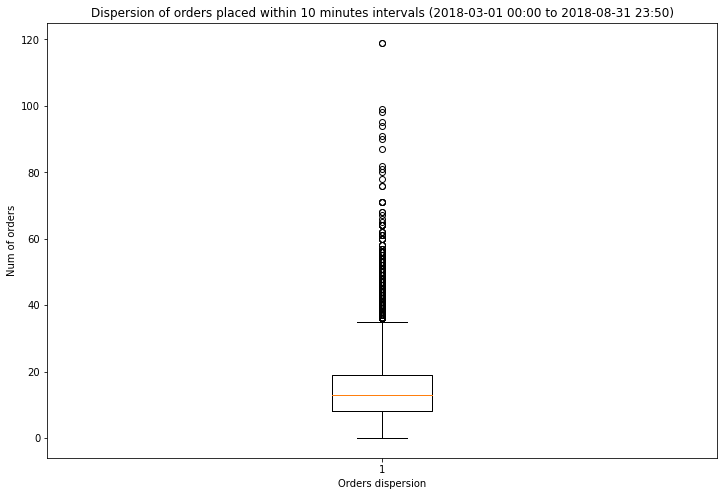

In [8]:
#plot dispersion of orders per 10 min gap
fig = plt.figure(figsize =(12, 8))
plt.boxplot(df['num_orders'])
plt.title('Dispersion of orders placed within 10 minutes intervals (2018-03-01 00:00 to 2018-08-31 23:50)')
plt.ylabel('Num of orders')
plt.xlabel('Orders dispersion')
plt.show()

In [9]:
#get statistics of num of orders
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

In [10]:
#check if data is in chronological order
print(df.index.is_monotonic)

True


### Data overview

The dataset contains information for the number of orders placed every 10 minutes, from March 1, 2018 to August 31, 2018.

There are no duplicated dates, and the rows are sorted in chronological order.

As for orders dispersion, we can see that they are widely spread out, starting at a minimum of 0, and reaching to a maximum of 119 in peak hours.

In spite of visualizing many outliers at the top of the boxplot, we notice that the median and the mean aren't too distant from one another (13 vs 14). Still, the standard deviation from the mean is more than half of it.

Provided that no fixes need to be made, we will proceed to tune hyperparameters for different models using the train set (90%) and evaluate RMSE on the test set (10%), making sure a score lower than 48 is achieved by at least one of the models.


## Analysis

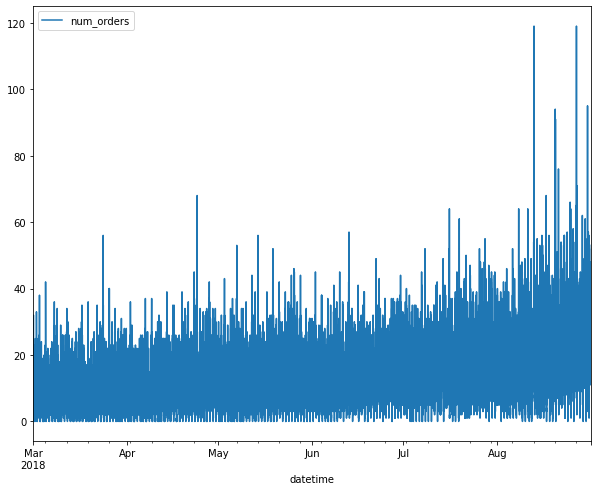

In [11]:
#plot the time series graph
df.plot(figsize=(10,8))
plt.show()

The chart above is not really informative. We can see many spikes but we can't distinguish if they are related to one or more specific days of the week, or to a given day hour where the demand increases.

As we'll train the models taking the sum of orders placed every hour, we will proceed to re-group data on such basis.

In [12]:
#Change the frequency from 10 minutes to one hour, and add up values using the sum function
df= df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
#print length after grouping

len(df)

4416

In [14]:
#check length is correct (initial length/current length= 6 intervals of 10 min per hour /1 interval of 60 min per hour)
26496/len(df)-60/10

0.0

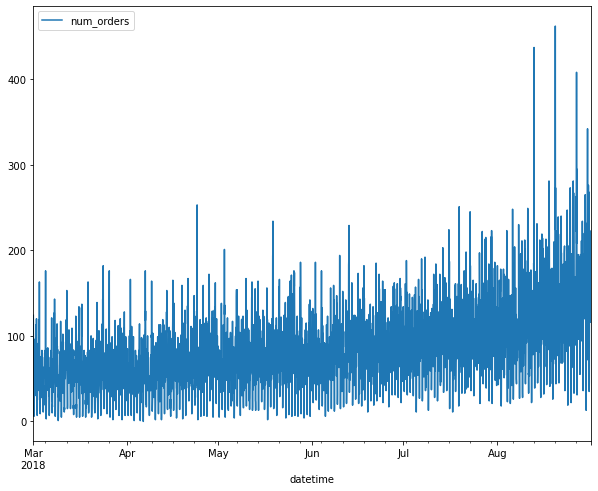

In [15]:
#re-plot
#plot the time series graph
df.plot(figsize=(10,8))
plt.show()

Even after grouping data considering a longer period, we can't get any clear insight from its plotting. Let's see if we can spot any patterns or seasonality by decomposing the dataset.

### Trends and seasonality

A trend is a smooth change of the mean value of the series without repeating patterns. For example, annual increase in sales of airline tickets.


Seasonality means cyclically repeating patterns in a time series. For instance, the growth of airline tickets sales each summer.


Trends and seasonality depend on the scale of the data. You cannot see the patterns repeating every summer if there is data only for one year. In this case, we only have data for one year, so we could come across an increase in orders at some point of each month, for example, but not at a given season each year.

For more easily detecting seasonality we'll take daily orders instead of hourly, and take a period of 10 days for decomposing it.

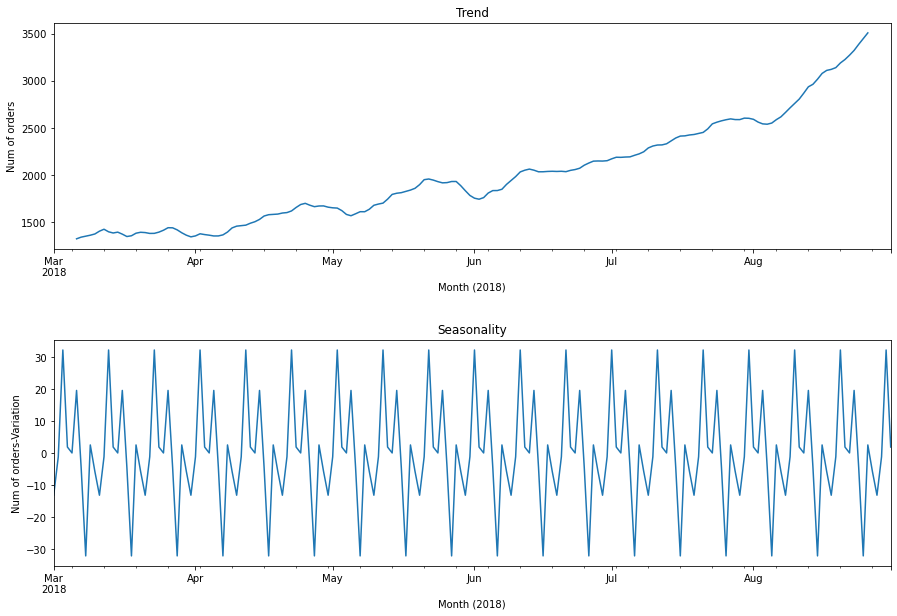

In [16]:
#Plot trends and seasonality
df_daily= df.resample('1D').sum()
decomposed=seasonal_decompose(df_daily,period=10)

plt.figure(figsize=(15, 10))

plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())

plt.title('Trend')
plt.xlabel('Month (2018)')
plt.ylabel('Num of orders')

plt.subplot(212)

decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.xlabel('Month (2018)')
plt.ylabel('Num of orders-Variation')

plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

The graphs above are much informative than the ones plotted before.

Regarding trends, we can clearly see that there's a monthly increase along the year, spiking steeply in August.

As for seasonality, each month we can spot a similar cycle repeating three times: Orders hike at the start of the month, reaching a maximum, then they lower down a bit, and make a second lower peak, after which they decrease steeply to their minimum, followed by a smooth recovery that leads to the next repetition.

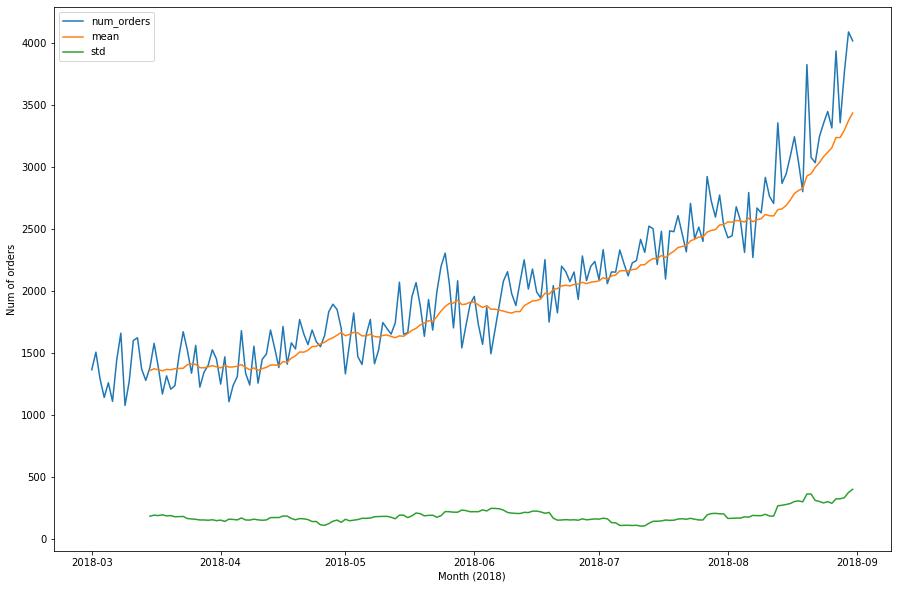

In [17]:
#Plot daily num of orders, and rolling average and standard deviation calculated for the previous 15 days (includes the 
#current value)

#define size
plt.figure(figsize=(15, 10))

#get rolling mean and std calculated for the preceeding 15 days
df_daily['mean'] = df_daily['num_orders'].rolling(15).mean()
df_daily['std'] = df_daily['num_orders'].rolling(15).std()

#plot df
plt.plot(df_daily) 

#add legend
plt.legend(df_daily.columns)

#add y label
plt.ylabel('Num of orders')

#add x label
plt.xlabel('Month (2018)')

plt.show()



In this plot, we can see the trends and seasonality patterns described before combined for the number of daily orders.


The progressive raise in the rolling mean is consistent with the trend we detected earlier.

As for the standard deviation, it seems rather constant, and probably due to seasonality cycles happening monthly.

### Time Series Differences

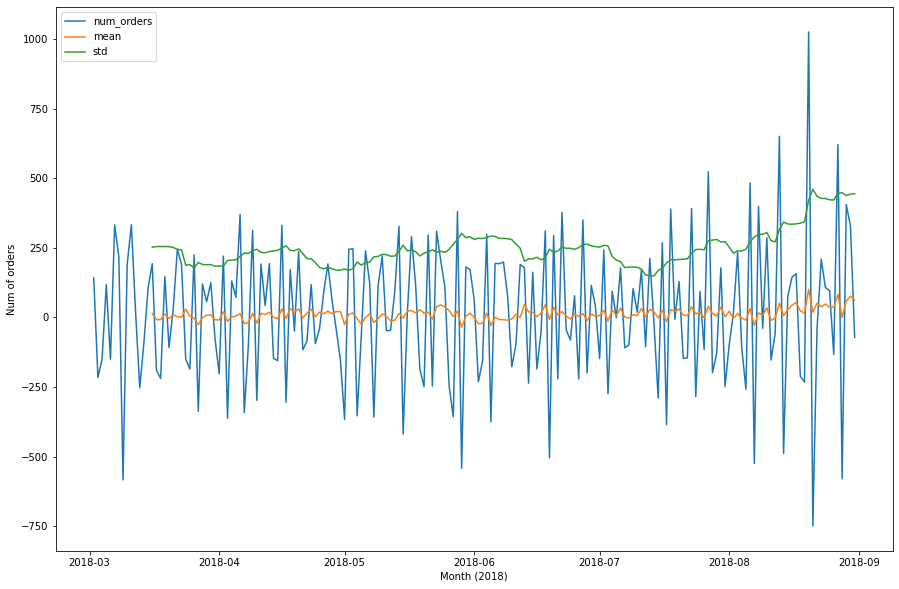

In [18]:
#define size
plt.figure(figsize=(15, 10))

#make df with difference between current and previous value
df_dif=df_daily-df_daily.shift(1)

#get the rolling mean and std for 15 days
df_dif['mean'] =df_dif['num_orders'].rolling(15).mean()
df_dif['std'] = df_dif['num_orders'].rolling(15).std()

#plot df
plt.plot(df_dif) 

#add legend
plt.legend(df_dif.columns)

#add y label
plt.ylabel('Num of orders')

#add x label
plt.xlabel('Month (2018)')

plt.show()


This chart reveals that the number of daily orders are not actually correlated to the orders placed in the immediately previous day.

The mean variation from day to day is stable, as well as the standard deviation, which only increases a bit in August, when the num of orders is higher.

### Forecast accuracy

We will now measure the accuracy of time series forecasting to then perform models sanity check.

We'll train a model with a forecast horizon of one day. Models like this are useful for automating technical decision-making.

We'll be using the RMSE metric to evaluate the models later on.

There are two ways to forecast time series without training:

1) All values of the test sample are predicted with the same number (a constant). For the MAE metric, this number is the median.

2) The new value x(t) is predicted by the previous value in the series, defined as x(t-1). This method is metric-independent. Note that the latest value of the train data can be used as the first value of the test data.

In this case, we will use the second method

In [19]:
#Define a function to get the root mean squared error

def rmse(pred,target):
    rmse= (mean_squared_error( target,pred))**0.5
    return rmse

In [20]:
#First off, test the RMSE of a model predicting always the previous value


train_benchmark, test_benchmark = train_test_split(df, test_size=0.10,  shuffle=False)

pred_previous = test_benchmark.shift(1,fill_value=train_benchmark.iloc[-1].values[0]) 


rmse_benchmark= rmse(pred_previous, test_benchmark)

rmse_benchmark


58.856486242815066

As expected from the introductory analysis, a model prediciting always the previous value gets too high a RMSE score (11 orders above the minimum accepted of 48)

### Creating features

Coming up, we will create features for a one-step forecast horizon.



In [21]:
#Write a function for creating features. 

def make_features(data, max_lag, rolling_mean_size, feature_col):
    #Parse each type of feature

    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    #for lag =1 to maax lag, add a column that brings the n-lag value for the feature col
    for lag in range (1, max_lag+1):
        data['lag_'+str(lag)]= data[feature_col].shift(lag)
    
    #get the rolling mean for the window width specified in rolling_mean_size excluding the
    #current value of each row
    
    data['rolling_mean'] = data[feature_col].shift(1).rolling(rolling_mean_size).mean()

In [22]:
#apply function to dataframe
make_features(df, 7,5 ,'num_orders')
df.head(10)

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,5,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,77.8
2018-03-01 06:00:00,12,3,1,6,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,54.2
2018-03-01 07:00:00,15,3,1,7,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,39.6
2018-03-01 08:00:00,34,3,1,8,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,28.4


In [23]:

#Drop rows with NaN values
df.dropna(axis=0, inplace=True)

#split into train and test sets

train, test = train_test_split(df,  shuffle=False, test_size=0.1)

#separate features from target in train set
features_train= train.drop('num_orders', axis=1)
target_train= train['num_orders']

#separate features from target in test set
test_features= test.drop('num_orders',axis=1)
test_target= test['num_orders']

## Training

For choosing the best hyperparameters, we will only use the train set. 

We will create a function to apply cross validation as described in this [article](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4#:~:text=The%20method%20that%20can%20be,for%20the%20forecasted%20data%20points).

As explained there, the method that can be used for cross-validating the time-series model is cross-validation on a rolling basis. Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.


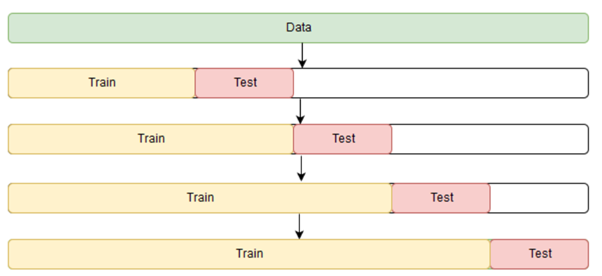

In [24]:
# set the block size if there are only three of them


def cross_val_rmse(features, target, model):
    #reset index to loop thorugh integers
    features=features.reset_index(drop=False)
    target=target.reset_index(drop=False)
    
    #test set= 10% of the total train set
    sample_size= len(features)//10
    
    #list to append rmses for each subset
    scores=[]
    
    #train set will be formed starting at index 0 and extending up to i+1
    #test set will start at i+1 and end at i+sample_size+1
    
    for i in range(sample_size, len(features)-sample_size, sample_size):
        train_indexes =range(0,i+1)
        valid_indexes = range(i+1, i+sample_size+1) # < write an array of indices for the validation block >
        
        
       # Split variables features and target into samples features_train, target_train, features_valid, target_valid
        features_train = features.iloc[train_indexes].set_index('datetime')
        features_valid = features.iloc[valid_indexes].set_index('datetime')
        target_train = target.loc[train_indexes].set_index('datetime')['num_orders']
        target_valid = target.loc[valid_indexes].set_index('datetime')['num_orders']
    
        #define model
        model = model
        
        #fit model
        model.fit(features_train, target_train)
        
        #make predictions
        pred=model.predict(features_valid)
        
        #score predictions
        score = rmse(pred, target_valid ) # < evaluate model quality >
        
        #append score
        scores.append(score)
        
    #return average of RMSEs achieved
    return sum(scores)/len(scores)

In [25]:
def rmse_final(train_features, train_target, test_features, test_target, model):
    model.fit(train_features, train_target)
    pred= model.predict(test_features)
    rmse_final= rmse(pred, test_target)
    return rmse_final

### 1) Linear regression model

In [26]:
#define Linear regression model

model_linear=LinearRegression()

#get rmse applying cross validation on the train set
linear_rmse=cross_val_rmse(features_train, target_train, model_linear)

#print rmse
linear_rmse

31.008289596873063

In [27]:
#final RMSE (on test set)

#store final rmse
linear_rmse_final= rmse_final(features_train, target_train, test_features, test_target, model_linear)

#print final rmse
linear_rmse_final

52.73988481092024

### Linear regression performance

Linear regression performs poorly on the test set. However, if we look at the average RMSE achieved by the cross-validation function, we see that it's considerably lower.

For such reason, it might be a good idea to shorten the time window of the train set to take only dates that are not too far from the target set when values are changing considerably over time as in this case.

### 2) Decision tree

In [28]:
%%time
#Iterate thorugh different hyperparameters and store the model achieving the lowest RMSE
best_tree = None
best_result_tree = 45


for depth in range(1,100): # choose hyperparameter range
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth= depth) # train model on training set
    
    rmse_tree= cross_val_rmse(features_train, target_train, model_tree)

    
    if rmse_tree < best_result_tree:
        best_tree = model_tree
        best_result_tree = rmse_tree
    
        
print(f'Best tree:{best_tree}')
print(f'Lowest RMSE: {best_result_tree}')

Best tree:DecisionTreeRegressor(max_depth=7, random_state=12345)
Lowest RMSE: 27.99942923013532
Wall time: 12.1 s


In [29]:
#Get RMSE on the test set
tree_rmse_final= rmse_final(features_train, target_train, test_features, test_target,best_tree)
tree_rmse_final


50.10727678746385

### Decision tree performance

We could not manage to diminish RMSE that much by implementing a single tree. Therefore, we'll try out a Random forest.

### 3) Random forest

In [30]:
%%time
#set placeholder for model and benchmark for rmse
best_forest = None
best_result_forest = 52


#iterate through dif hyperparameters
for est in range( 50, 101, 10):
    for depth in [None,9 ,50,100]: 
        for leaf in [2,5,10]:
            
            #define model
            model_forest = RandomForestRegressor(random_state=12345, max_depth= depth,n_estimators=est, min_samples_leaf=leaf) # train model on training set
            
            #get rmse using cross validation
            rmse_forest=   cross_val_rmse (features_train, target_train, model_forest)
            
            #store the model with the lowest rmse 
            if rmse_forest <= best_result_forest:
                best_forest = model_forest
                best_result_forest= rmse_forest

    
        
print(f'Best Randome forest:{best_forest}')
print(f'Lowest RMSE: {best_result_forest}')

Best Randome forest:RandomForestRegressor(max_depth=100, min_samples_leaf=2, random_state=12345)
Lowest RMSE: 24.130399659656227
Wall time: 10min


In [31]:
#get RMSE on the test set
forest_rmse_final=  rmse_final(features_train, target_train, test_features, test_target,best_forest)
forest_rmse_final


44.962323001562865

### Random forest performance

By using a forest we managed to achieve a lower result than our target RMSE of 48. This means that cross validation was an effective method for choosing the best parameters, and the model made more accurate predictions than linear regression and the decision tree tested above.

However, we can notice that it took rather long to choose the best parameters.

### 4) Light GBM

In [32]:
%%time
#set placeholder for model and benchmark for rmse
best_lgbm = None
best_rmse_lgbm= 48

#Iterate through different hyperparameters

for est in range(50,101,50):
    for depth in [50,100]:
        for rate in [0.1,0.5,0.01]:
            
            #define model
            model_gbm = lgb.LGBMRegressor(num_leaves= 30, max_depth=depth, 
                            random_state=12345, 
                            n_estimators=est,
                            colsample_bytree=0.9,
                            subsample=0.9,
                            learning_rate= rate,
                            )

            #calculate rmse using cross-val
            rmse_lgbm= cross_val_rmse (features_train, target_train, model_gbm)
            
            #store the model with the lowest RMSE
            if rmse_lgbm <= best_rmse_lgbm:
                best_lgbm = model_gbm
                best_rmse_lgbm= rmse_lgbm
            
print(f'Best parameters: {best_lgbm}')
print(f'Best rmse: {best_rmse_lgbm}')

Best parameters: LGBMRegressor(colsample_bytree=0.9, max_depth=100, n_estimators=50,
              num_leaves=30, random_state=12345, subsample=0.9)
Best rmse: 24.03935144749496
Wall time: 12.8 s


In [33]:
#get rmse on the test set 
lgbm_rmse_final = rmse_final(features_train, target_train, test_features, test_target,best_lgbm)
lgbm_rmse_final


43.79225355131786

### Light GBM performance

Light GBM performed even a bit better than the Random Forest regressor, and it took considerably shorter to tune hyperparameters.

### 5) Catboost

In [34]:
%%time
#set placeholder for model and benchmark for rmse

best_model_cat=None
best_rmse_cat=50

#try out differnt hyperparameters
for rate in [0.05,0.1, 0.5]:
    for depth in [5, 10,15]:
        for leaf in [3,7,9,12]:
            
            #define model
            model_cat = CatBoostRegressor(iterations=10,
                        learning_rate=rate,
                        depth=depth,
                        l2_leaf_reg=leaf,
                        model_size_reg=None,
                        rsm=None,
                        loss_function='RMSE', verbose= False)
            
            #calculate rmse using cross-val                            
            cat_rmse= cross_val_rmse(features_train, target_train, model_cat)
            
            #store the model with the lowest RMSE                                 
            if cat_rmse <= best_rmse_cat:
                best_model_cat=model_cat
                best_rmse_cat=cat_rmse
                


print(f'Best rmse: {best_rmse_cat}')

Best rmse: 25.40054345160617
Wall time: 6min 56s


In [35]:

#get rmse on the test set
cat_rmse_final= rmse_final(features_train, target_train, test_features, test_target,best_model_cat)
cat_rmse_final


53.1660443224078

### Catboost performance

Catboost took the longest to tune hyperparameters, and yet did not manage to fall below the 48 rmse thershold on the test set.

### 7) XGBoost regressor



In [36]:
%%time

#set placeholder for model and benchmark for rmse
best_model_xgb=None

best_xgb_rmse=45

#Iterate through different hyperparameters and choose the one that achieves the lowest RMSE

for depth in [1,3,6]:
    for estimators in [50,100,500]:
        for rate in [0.001, 0.01, 0.1]:
            
             #define model
            model_xgb= XGBRegressor(max_depth=depth, n_estimators=estimators, learning_rate=rate, min_child_weight=1, subsample=1)
            
             #calculate rmse using cross-val
            xgb_rmse= cross_val_rmse(features_train, target_train, model_xgb)
            
            #store the model with the lowest RMSE
            if xgb_rmse<best_xgb_rmse:
                best_model_xgb=model_xgb
                best_xgb_rmse=xgb_rmse
                
            
            
            
print(f'Best xgb model :{best_model_xgb}')
            
            
print(f'Best xgb rmse :{best_xgb_rmse}')

Best xgb model :XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
Best xgb rmse :24.169956846542938
Wall time: 1min 3s


In [37]:
#get rmse on the test set

xgb_rmse_final= rmse_final(features_train, target_train, test_features, test_target,best_model_xgb)
xgb_rmse_final


45.70973503511235

### XGBoost regressor performance

XGBooster also managed to achieve an RMSE lower than 48 on the test set.

## Testing - Summary

In [38]:
#Create a dataframe with results


table_comp = pd.DataFrame({
                          'Linear regression': [linear_rmse_final],
                          'Decision tree regressor': [tree_rmse_final],
                          'Random forest regressor':[forest_rmse_final],
                          'LightGBM ':[lgbm_rmse_final],
                          
                          'CatBoost': [cat_rmse_final],
                          'XGBoost': [xgb_rmse_final]
                          }).T
table_comp=table_comp.rename(columns={0:'RMSE on test set'})
#sort by rmse in ascending order
table_comp= table_comp.sort_values(by=['RMSE on test set'],ascending=True)
#print
table_comp
table_comp

,RMSE on test set
LightGBM,43.792254
Random forest regressor,44.962323
XGBoost,45.709735
Decision tree regressor,50.107277
Linear regression,52.739885
CatBoost,53.166044


### Conclusion

Based on the table above, we can say that the models that meet the requirement of scoring an RMSE lower than 48 on the test set are:

- LightGBM (with a tunning time of 12.8 s)
- Random Forest Regressor (10 min)
- XGBooster (1 min 3 sec).

If we had to pick one, it'd definetly be Light GBM.
